# Traffic Analysis I-94: Too Much Traffic

We're going to analyze a dataset about the westbound traffic on the I-94 Interstate highway.

John Hogue made the dataset available, and you can download it from the UCI Machine Learning Repository.

The goal of our analysis is to determine a few indicators of heavy traffic on I-94. These indicators can be weather type, time of the day, time of the week, etc.

Lets upload our modules and take a peek at the dataset.

Additionally, we are given the following data dictionary:

* holiday - Categorical US National holidays plus regional holiday, Minnesota State Fair
* temp - Numeric Average temp in kelvin
* rain_1h - Numeric Amount in mm of rain that occurred in the hour
* snow_1h - Numeric Amount in mm of snow that occurred in the hour
* clouds_all - Numeric Percentage of cloud cover
* weather_main - Categorical Short textual description of the current weather
* weather_description - Categorical Longer textual description of the current weather
* date_time - DateTime Hour of the data collected in local CST time
* traffic_volume - Numeric Hourly I-94 ATR 301 reported westbound traffic volume

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme()

traffic = pd.read_csv('D:/Library/datasci/datasets/Metro_Interstate_Traffic_Volume.csv', encoding = "Latin-1")

In [10]:
traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [7]:
traffic.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [8]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


We have a dataset of 9 columns, with about 48000 rows of interest. Additionally we have zero missing values.  Each data point is a snapshot of a given hour between 2012 and 2018. The target variable of interest is traffic_volume, an integer number which measures the number of cars per that recorded hour.

A station located approximately midway between Minneapolis and Saint Paul records the traffic data (see the dataset [documentation](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume)). For this station, the direction of the route is westbound (i.e., cars moving from east to west). This means that the results of our analysis will be about the westbound traffic in the proximity of the station. In other words, we should avoid generalizing our results for the entire I-94 highway.

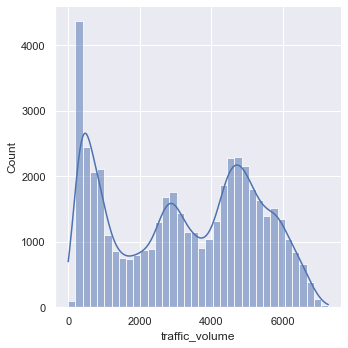

In [15]:
sns.displot(traffic.traffic_volume, kind = 'hist', kde = True)

In [16]:
traffic.traffic_volume.describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

We have a trimodal distribution. Generally, distributions with multiple modes have some sort of explanation for each of the peaks. We see a peak at very low values of traffic volume (100-400), another at medium values (2800-3400) and nother at higher values, (4200-5000). These could represent different times of day such as nighttime, morning and evening rush hours. Additionally, it could simply be two different distributions with overlap in the middle (Night/Day). 

### Time variables

Lets try seperating the nighttime and daytime data. We will say that 7am to 7pm is daytime, and 7pm to 7am is nighttime.

In [20]:

traffic.date_time = pd.to_datetime(traffic['date_time'])

traffic.date_time.head()

0   2012-10-02 09:00:00
1   2012-10-02 10:00:00
2   2012-10-02 11:00:00
3   2012-10-02 12:00:00
4   2012-10-02 13:00:00
Name: date_time, dtype: datetime64[ns]

In [53]:
traffic['day'] = traffic['date_time'].dt.hour.apply(lambda x: 1 if x in [7,8,9,10,11,12,13,14,15,16,17,18] else 0)

traffic.day.value_counts()

0    24327
1    23877
Name: day, dtype: int64

<AxesSubplot:xlabel='traffic_volume', ylabel='Count'>

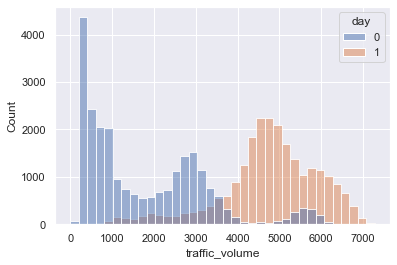

In [54]:
sns.histplot(data = traffic, x = "traffic_volume", hue = "day")

We have a difference in the number of recorded day and night hours at 24327 night against 23877 day hours. There must be a few hours of missing data.

Above I have created a new categorical variable in the dataset called 'day' which returns 1 if the hour is a daytime hour (7-16:59) and 0 if it is nighttime. 

We have plotted the traffic volume by day on the above histogram. We see that daytime hours have on average much more traffic than the nighttime hours. Time seems to be a heavy indicator so we will add some more time based columns. Those columns are as follows:

* Month - 1 - 12 for Jan - Dec
* dayofweek - 0-6 for Monday - Sunday
* hour - 0-23 on the 24 hour clock

In [63]:
traffic['month'] = traffic['date_time'].dt.month
traffic['dayofweek'] = traffic['date_time'].dt.weekday
traffic['hour']= traffic['date_time'].dt.hour

<AxesSubplot:xlabel='month', ylabel='traffic_volume'>

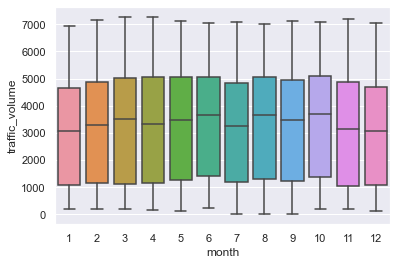

In [57]:
sns.boxplot(data = traffic, x = "month", y = 'traffic_volume')

<AxesSubplot:xlabel='dayofweek', ylabel='traffic_volume'>

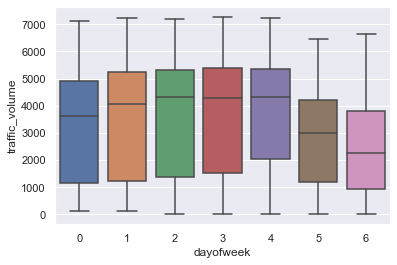

In [64]:
sns.boxplot(data = traffic, x = "dayofweek", y = 'traffic_volume')

<AxesSubplot:xlabel='hour', ylabel='traffic_volume'>

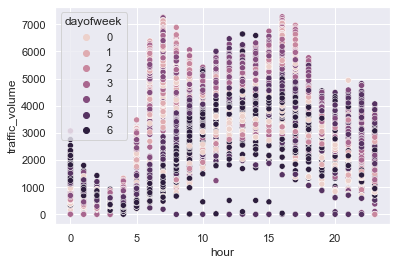

In [67]:
sns.scatterplot(data = traffic, x = "hour", y = 'traffic_volume', hue = 'dayofweek')

On the monthly chart, traffic volume does pull back a bit in the winter and ramp up in the summer by ~10-15%.

We have significant variation based off of hour and weekday. Lets see if we can isolate the hourly chart by the weekend vs the weekday.

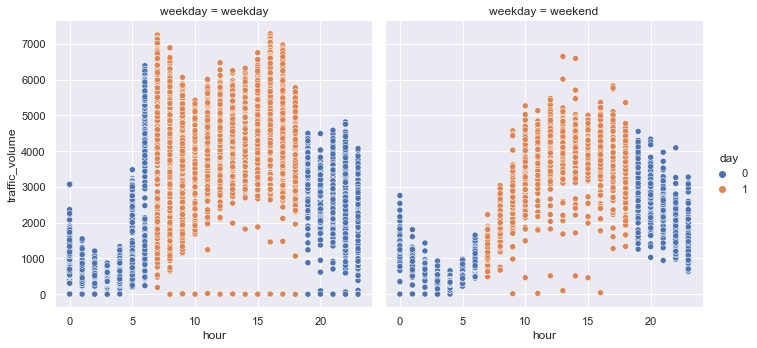

In [76]:
traffic['weekday'] = pd.cut(traffic['dayofweek'], [0,5,10], labels = ['weekday','weekend'])
sns.relplot(data = traffic, x = 'hour', y = 'traffic_volume', col = 'weekday', hue = 'day')

Weekdays have a significantly higher traffic volume all day long. Particularly in the early morning around rush hour (7-9). This is also true for the early morning rush hour for the nighttime data (hours 5,6). Nights outside these hours seem to have much closer traffic volume. 

### Weather Variables

We have taken a look at the time variables and determined that there is a slight traffic increase in warm months, differences between the weekdays and weekends, and finally there are variations based off of daytime or nighttime.

Now we will see if there are any weather effects. Particularly the variables temp, rain_1h, snow_1h, clouds_all, weather_main, weather_description.

#### Numeric
First we can look at the numeric variables vs hourly traffic. The numeric variables of these are: temp, rain_1h, snow_1h, clouds_all.

Below is a function from a previous work which should make getting scatter plots with correlation quite easy.

In [87]:
def plot_scatter(df, col, target):
    corr = df[[col, target]].corr()[col][1]
    
    c = ["red"] if corr >= 0.7 else (["brown"] if corr >= 0.3 else\
                                    (["lightcoral"] if corr >= 0 else\
                                    (["blue"] if corr <= -0.7 else\
                                    (["royalblue"] if corr <= -0.3 else ["lightskyblue"])))) 
    
    fig, ax = plt.subplots(figsize = (5, 5))
    
    sns.scatterplot(x = col, y = target, data = df, c = c, ax = ax)        
    ax.set_title("Correlation between " + col + " and " + target + " is: " + str(corr.round(4)))

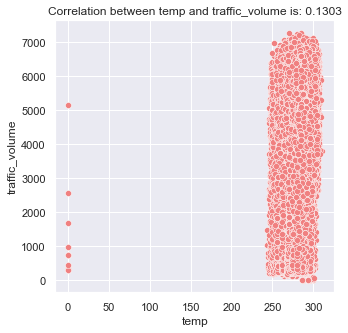

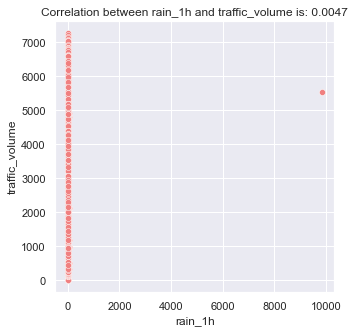

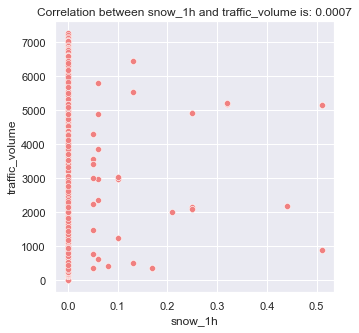

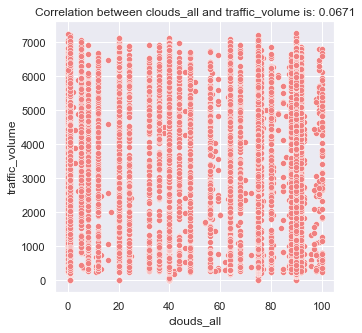

In [89]:
numeric_cols = ['temp', 'rain_1h', 'snow_1h', 'clouds_all']


for col in numeric_cols:
    plot_scatter(traffic, col, 'traffic_volume')

We do have some outliers. Lets get rid of them in rain_1h and the temp columns and try this again.

In [90]:
traffic = traffic[traffic['rain_1h'] < 100]
traffic = traffic[traffic['temp'] > 200]

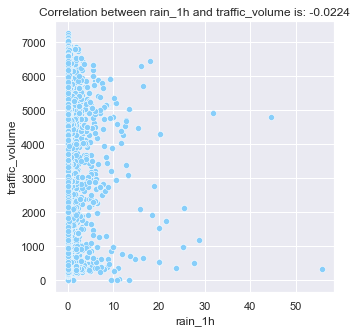

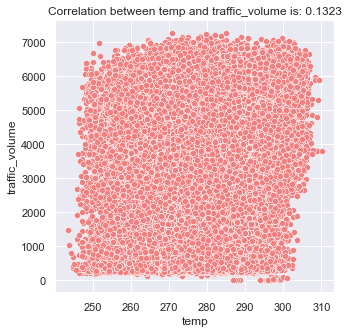

In [91]:
x = ['rain_1h', 'temp']

for col in x:
    plot_scatter(traffic, col, 'traffic_volume')

Even without the outliers there is insignificant correlation between these two variables. Technically I believe the p-value of pearson's correlation test is < 0.05 for temp and traffic_volume but there is likely covariance from the month.

#### Categorical

Lets look at the weather_main and weather_description categories.

In [93]:
traffic.weather_main.unique()

array(['Clouds', 'Clear', 'Rain', 'Drizzle', 'Mist', 'Haze', 'Fog',
       'Thunderstorm', 'Snow', 'Squall', 'Smoke'], dtype=object)

In [94]:
traffic.weather_description.unique()

array(['scattered clouds', 'broken clouds', 'overcast clouds',
       'sky is clear', 'few clouds', 'light rain',
       'light intensity drizzle', 'mist', 'haze', 'fog',
       'proximity shower rain', 'drizzle', 'moderate rain',
       'heavy intensity rain', 'proximity thunderstorm',
       'thunderstorm with light rain', 'proximity thunderstorm with rain',
       'heavy snow', 'heavy intensity drizzle', 'snow',
       'thunderstorm with heavy rain', 'freezing rain', 'shower snow',
       'light rain and snow', 'light intensity shower rain', 'SQUALLS',
       'thunderstorm with rain', 'proximity thunderstorm with drizzle',
       'thunderstorm', 'Sky is Clear', 'very heavy rain',
       'thunderstorm with light drizzle', 'light snow',
       'thunderstorm with drizzle', 'smoke', 'shower drizzle',
       'light shower snow', 'sleet'], dtype=object)

In [105]:
by_weather_main = traffic.groupby('weather_main').mean()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,day,month,dayofweek,hour
weather_main,,,,,,,,,
Clear,281.700337,0.000000,0.000000,1.547866,3057.207458,0.429116,6.492863,3.117854,11.232718
Clouds,281.466101,0.000000,0.000000,64.056120,3618.449749,0.573859,6.342786,2.991625,12.467753
Drizzle,283.795431,0.157512,0.000000,82.319605,3290.727073,0.484898,6.843493,2.863811,11.447007
Fog,279.415713,0.087007,0.000625,51.497807,2703.720395,0.396930,6.695175,2.958333,7.992325
Haze,275.818581,0.046868,0.000000,58.670588,3502.101471,0.613235,5.761029,2.816176,11.492647
Mist,279.476892,0.238336,0.000728,65.956303,2932.956639,0.435798,6.749748,2.905042,9.495966
Rain,286.976918,0.547849,0.000187,72.599365,3317.514548,0.500794,6.794922,2.911127,11.633574
Smoke,290.927500,0.527000,0.000000,53.350000,3237.650000,0.600000,6.300000,2.950000,10.900000
Snow,267.955188,0.025223,0.001655,81.465229,3016.844228,0.505563,6.279555,2.791029,11.096314


In [102]:
by_weather_description = traffic.groupby('weather_description').mean()

<AxesSubplot:xlabel='traffic_volume', ylabel='weather_main'>

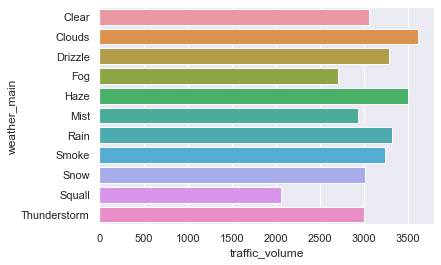

In [111]:
sns.barplot(data = by_weather_main, x = 'traffic_volume', y = by_weather_main.index)

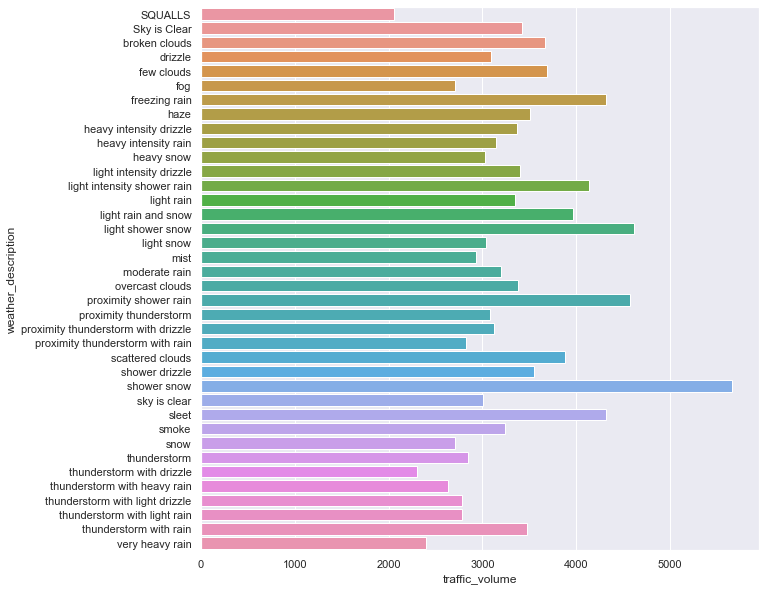

In [117]:
plt.figure(figsize = (10,10))
sns.barplot(data = by_weather_description, x = 'traffic_volume', y = by_weather_description.index)
plt.show()

We see that a few weathers stick out. Using 4000 traffic volume as a cutoff we can see that the following variables result in high traffic:

* shower snow
* proximity shower rain
* light shower snow
* freezing rain
* sleet

This is actualy some of the 'lighter' weather on the list. It may be that the weather isn't bad enough to deter people from driving, however still significant enough to cause slowdowns. Additionally, some of this weather may cause particularly big slowdowns at night such as freezing rain or sleet.

### Conclusion

This project was to find a few indicators of heavy traffic on the westbound I-94 interstate highway. We investigated two types:

* Time indicators
    - The traffic is heavier during the warm months (March - Oct) compared to the cold months (Nov-Feb).
    - Traffic is heavier on business days compared to the weekends.
    - Traffic is heavier during rush hours, 5-17 during the week, and 7-17 during the weekend.
* Weather Indicators
    - shower snow
    - proximity shower rain
    - light shower snow
    - freezing rain
    - sleet

